In [2]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.interpolate as si
from pandas import DataFrame as pddf
from pandas import Series as pds
import bisect
import csv
import glob

import os
import sys
module_path = os.path.abspath(os.path.join('/Users/maxime/Programme/fitderivpackage1.02/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from fitderiv import fitderiv 





In [3]:
def loadData(path):
    drpfiles=[path+'droplets/' + f for f in listdir(path + 'droplets/') if isfile(join(path + 'droplets/',f)) and f!='.DS_Store']
    i=0
    df={}
    for file in drpfiles:
        df[i]=pd.read_csv(file)
        i+=1 

        #create the template file in hiccup mode
    tpfile=pd.read_csv(path+'template.csv', header=4)
    tpFileOrd=tpfile.set_index('order')
    label=list(set(tpfile['description']))
    label2=[l for l in label if l!='Empty' and l!='CAA']
    dropMap=[]


    for i in range(0,len(tpFileOrd)-1,2):
        for j in range(tpFileOrd.droplet_number[i]+tpFileOrd.droplet_number[i+1]):
            if j%2==0 :
                dropMap.append([tpFileOrd.well[i], tpFileOrd.description[i]])
            else : 
                dropMap.append([tpFileOrd.well[i+1], tpFileOrd.description[i+1]])

    dropMap=np.array(dropMap)
    
    return [dropMap, df, label2]

In [75]:

def poolData(dropMap, df, label,channel, incCarte=5e-3, nbReps=80, timeThresh=30, threshOutlayer=17): 
    for j,tmp in enumerate(label):
        dataX=np.array([])
        dataY=np.array([])
        data=pddf()

        print(tmp)
        nbAdded=0

        for j,content in enumerate(dropMap[:,1]):

            y=[]
            x=[]
            if content==tmp:    
                if channel=='RFP':
                    p=df[j]
                    y=np.array(np.log(p.fluo_2_area*p.speed/p.size),dtype=np.float64)
                    x=np.array(p.time/3600) 
                    ystd=np.array(np.divide(p.fluo_2_std+incCarte/2,p.fluo_2_median))
                if channel=='GFP':
                    p=df[j]
                    y=np.array(np.log(p.fluo_3_area*p.speed/p.size),dtype=np.float64)
                    x=np.array(p.time/3600,dtype=np.float64)
                    ystd=np.array(np.divide(p.fluo_3_std+incCarte/2,p.fluo_3_median))

                if channel=='PVD':
                    p=df[j]
                    y=np.array(np.log(p.fluo_1_area*p.speed/p.size))
                    x=np.array(p.time/3600,dtype=np.float64)
                    ystd=np.array(np.divide(p.fluo_1_std+incCarte/2,p.fluo_1_median),dtype=np.float64)

                #filtre outlayer
                idxThres=bisect.bisect(x, timeThresh)
                idxOutlayer=bisect.bisect(x, threshOutlayer)

                if len(y)>idxOutlayer:
                    if y[idxOutlayer]>y[2]+1:
                        #save all the time en fluo of the drop from the same label. Remove run 0.
                        dataX=np.append(dataX, x[2:idxThres])
                        dataY=np.append(dataY, y[2:idxThres])
                        nbAdded+=1
                            
                        if nbAdded>nbReps:
                            break


        data=pddf({'fluo': dataY,'time': dataX})
        data=data.sort_values(by='time')
        data=data.reindex_axis(['time','fluo'], axis=1)
        data.to_csv(path+tmp+'.csv', index=False)


        


In [70]:
def checkData(folder,label,channel):
    for dataFile in label:
        file=folder+dataFile+'.csv'
        data=pd.read_csv(file)
        # load data
        t, od= np.array(data['time']), np.array(data['fluo'])
        fig=plt.figure()
        plt.scatter(t,od)
        plt.show()
        fig.savefig(folder+dataFile+'check'+channel+'.jpg')
    

In [6]:
def fitDataLM(folder,label): 

    for j,dataFile in enumerate(label):
        file=folder+dataFile+'.csv'
        data=pd.read_csv(file)
        # load data
        # d= np.loadtxt('data.txt')
        t, od= np.array(data['time']), np.array(data['fluo'])

        # redefine bounds and run inference
        #hyperparameters 
        #0: amplitude
        #1: flexibility
        #2: measurement error
        #initial    b= {0: [-1,5], 1: [-5,2], 2: [-7,1]}
        b= {0: [-1,5], 1: [-5,0], 2: [-1,0]}
        q= fitderiv(t, od, bd= b, logs= False)

        # plot results
        fig=plt.figure()
        #plt.subplot(2,1,1)
        q.plotfit('f')
        plt.show()
        fig.savefig(folder+dataFile+'fit.jpg')
        #plt.subplot(2,1,2)
        fig=plt.figure()
        q.plotfit('df')
        plt.show()
        fig.savefig(folder+dataFile+'derivative.jpg')


        # export results
        statdict=q.printstats()
        with open(folder+dataFile+'result.csv','w') as csv_file:
            writer = csv.writer(csv_file)
            for key, value in statdict.items():
                writer.writerow([key, value])

In [7]:
def barPlot(labelList,y,stdy,ymin,ymax,title,ylabel,path):
    # Build the plot
    fig, ax = plt.subplots()
    x_pos = np.arange(len(labelList))
    ax.bar(x_pos, y, yerr=stdy, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x_pos)
    plt.xticks(rotation=90)
    ax.set_xticklabels(labelList)
    ax.set_ylim([ymin,ymax])
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-05-24_green-red_CAA/analysis/
50-50
50-50-100uM
90pvdS-10WT
10pvdS-90WT


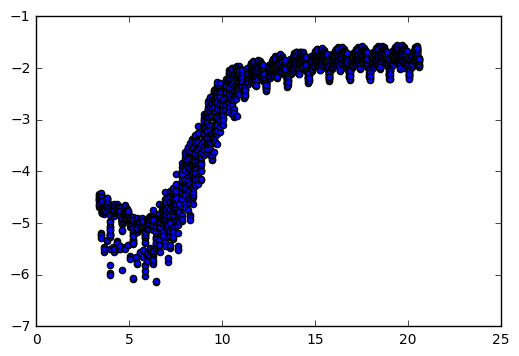

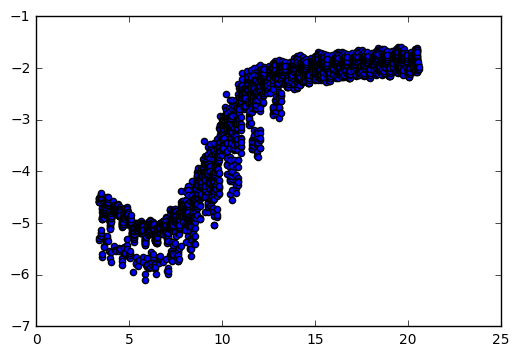

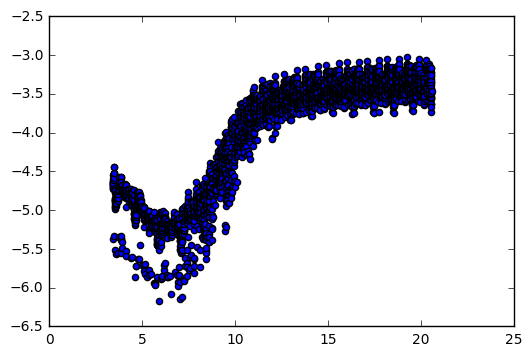

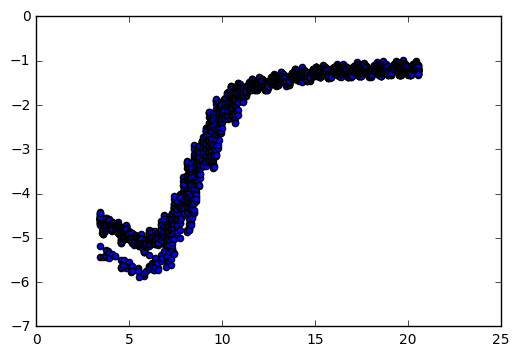

In [78]:
#rootPath='/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/'
#folder=rootPath+'analysis/'
rootPath='/Users/maxime/Documents/experiences/milli/MILLIDROP_manip/2018-05-24_green-red_CAA/'
folder=[rootPath+'analysis/']

#rootPath='/Users/maxime/Documents/experiences/milli/experienceDilutionWTstock2/'
#folder=[join(join(rootPath,o),'analysis/') for o in listdir(rootPath) if o[:3]=='201']

#label=['SBW25-WT_CAA_1000','SBW25-WT_CAA_7000']#'SBW25-WT_CAA_10', 'SBW25-WT_CAA_100', 

channel ='PVD'
incCarte=5e-3 #incertitude de lamesure par la carte hardware
nbReps=800
timeThresh=40 #heures
threshOutlayer=17#heures

for path in folder:
    print(path)
    [dropMap, df, label]=loadData(path)
    poolData(dropMap, df, label, channel, incCarte, nbReps, timeThresh, threshOutlayer)
    checkData(path, label,channel)
    #fitDataLM(path, label)

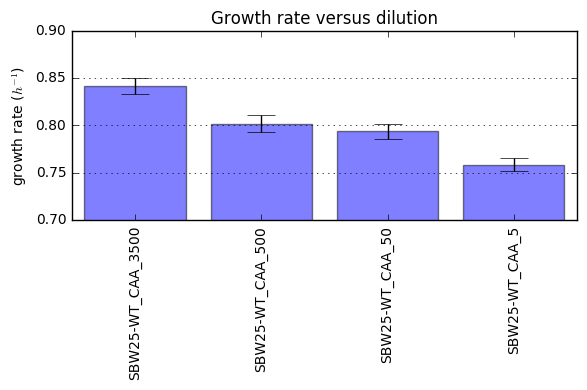

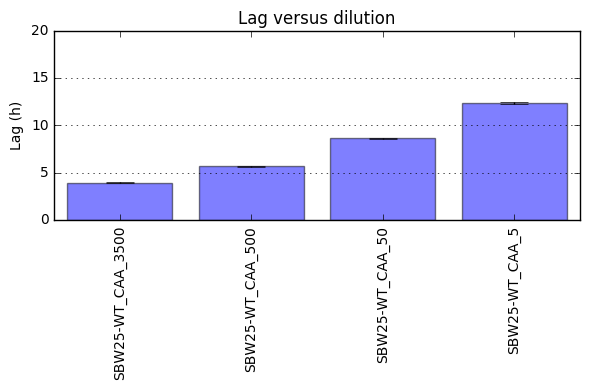

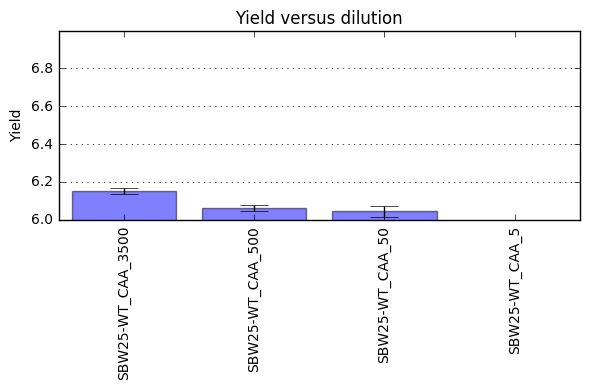

In [65]:
def findIdx(your_list,item):

    lst=pddf(your_list)
    lst2=lst[0].values
    lst3=lst2.tolist()
    return lst3.index(item)

gRateList=[]
stdgRateList=[]
lagList=[]
stdlagList=[]
yieldList=[]
stdyieldList=[]
labelList=[]

for path in [folder[2]]:
    #print(path)    
    #path='/Users/maxime/Documents/experiences/milli/expDilution_5_50_500_3500/2018-02-09_dilution_CAA_WT-stock2/analysis/'

    fileList=glob.glob(path+'*result.csv')
    
    
    for file in fileList:
        with open(file, 'r') as f:
            reader = csv.reader(f)
            your_list = list(reader)
        
        name=os.path.split(file)
        #print(your_list)

        
        stdgRateList.append(float(your_list[findIdx(your_list,'max df std')][1]))
        gRateList.append(float(your_list[findIdx(your_list,'max df')][1]))
        lagList.append(float(your_list[findIdx(your_list,'lag time')][1]))
        stdlagList.append(float(your_list[findIdx(your_list,'lag time std')][1]))
        yieldList.append(float(your_list[findIdx(your_list,'max y')][1]))
        stdyieldList.append(float(your_list[findIdx(your_list,'max y std')][1]))
        labelList.append(name[1][:-10])

barPlot(labelList,gRateList,stdgRateList,0.7,.9,'Growth rate versus dilution','growth rate ($ h^{-1}$)',rootPath+'gRate.png')
barPlot(labelList,lagList,stdlagList,0,20,'Lag versus dilution','Lag (h)',rootPath+'lag.png')
barPlot(labelList,yieldList,stdyieldList,6,7,'Yield versus dilution','Yield',rootPath+'yield.png')
